# NLP exploration - 3 (executed on Google Colab)
For each menu recipe, the goal is to:  
- select with NLP recipe similary task a bunch of database recipes that might match with the menu recipe (those with `score > max_score - radius`).
- using this preselection, build a new recipe which is as closest as possible to the menu recipe but does not necessarily coincide with a recipe from the database.

Tests are done here for the JOW database only.   
Results are compared with the outputs of GPT3.

## Import packages

In [ ]:
import pandas as pd
import numpy as np
import re
import time
import seaborn as sns
import itertools

## Google colab settings
Show the gpu infos and change if needed in "Execution" panel.   
Using GPUs is not compulsory here. I moved to Google Colab because my computer is slow.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Feb 15 15:17:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import from Google Drive.  
Here the folder 'carbondiet4GD' only contains the folder data/ with subfolders Recipes/ and Tools/ (others are not used).

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/carbondiet4GD.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')     # create a copy directly in colab for efficiency reasons

Mounted at /content/drive


**Indicate the path where the folder data/ is located.**

In [ ]:
#data_path = '../'
data_path = 'carbondiet4GD/'

## Import and prepare the menu database
Import the file that has been prepared with a list of menu recipes and their corresponding Jow recipes.   
Note that the matching has been done by hand in a former step (and may contain errors).

In [ ]:
menu_data = pd.read_excel(data_path+'data/Tools/MenuToJowRecipes_v1.xlsx', header = [0])
menu_data.head(10)

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand
0,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,NaN,Mousse au chocolat maison
1,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,NaN,Fondant au chocolat
2,9,burgart_205074_c70.jpg,Desserts,Financier artisan boulanger,NaN,"['Financier cerises noires & pistache', 'Finan..."
3,10,burgart_205074_c70.jpg,Boissons,Expresso,NaN,no match
4,11,burgart_205074_c70.jpg,Boissons,Café long,NaN,no match
5,12,burgart_205074_c70.jpg,Boissons,Chocolat chaud,NaN,Chocolat chaud
6,13,burgart_205074_c70.jpg,Boissons,Ice Tea,NaN,no match
7,14,burgart_205074_c70.jpg,Boissons,Elixia,Limonade Bio,no match
8,15,burgart_205074_c70.jpg,Boissons,Alain Milliat,"Orange, Mangue, Pomme",no match
9,16,burgart_205074_c70.jpg,Boissons,Bière Corona,NaN,no match


Prepare the list of queries for test, first by concatenating the title and subtitle of menu recipes 

In [ ]:
menu_data['Menu Title and Subtitle'] = menu_data.apply(lambda row: row['Menu Title'] + ", " + row['Menu Subtitle'], axis = 1)
menu_data.head()

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Menu Title and Subtitle
0,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,NaN,Mousse au chocolat maison,"Desserts, Mousse au chocolat maison"
1,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,NaN,Fondant au chocolat,"Desserts, Fondant au chocolat artisan boulanger"
2,9,burgart_205074_c70.jpg,Desserts,Financier artisan boulanger,NaN,"['Financier cerises noires & pistache', 'Finan...","Desserts, Financier artisan boulanger"
3,10,burgart_205074_c70.jpg,Boissons,Expresso,NaN,no match,"Boissons, Expresso"
4,11,burgart_205074_c70.jpg,Boissons,Café long,NaN,no match,"Boissons, Café long"


Replace NaN in the ingredients column by empty string

In [ ]:
menu_data = menu_data.fillna("")
menu_data.head()

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Menu Title and Subtitle
0,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"Desserts, Mousse au chocolat maison"
1,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,"Desserts, Fondant au chocolat artisan boulanger"
2,9,burgart_205074_c70.jpg,Desserts,Financier artisan boulanger,,"['Financier cerises noires & pistache', 'Finan...","Desserts, Financier artisan boulanger"
3,10,burgart_205074_c70.jpg,Boissons,Expresso,,no match,"Boissons, Expresso"
4,11,burgart_205074_c70.jpg,Boissons,Café long,,no match,"Boissons, Café long"


Do the same by concatenating the title, subtitle and ingredients of menu recipes

In [ ]:
def add_ingredients(row):
    if row['Menu Ingredients']=='':
        res = row['Menu Title'] + ", " + row['Menu Subtitle']
    else:
        res = row['Menu Title'] + ", " + row['Menu Subtitle'] + ", " + row['Menu Ingredients']
    return res

menu_data['Menu all'] = menu_data.apply(add_ingredients, axis = 1)
menu_data.head(8)

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Menu Title and Subtitle,Menu all
0,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison"
1,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger"
2,9,burgart_205074_c70.jpg,Desserts,Financier artisan boulanger,,"['Financier cerises noires & pistache', 'Finan...","Desserts, Financier artisan boulanger","Desserts, Financier artisan boulanger"
3,10,burgart_205074_c70.jpg,Boissons,Expresso,,no match,"Boissons, Expresso","Boissons, Expresso"
4,11,burgart_205074_c70.jpg,Boissons,Café long,,no match,"Boissons, Café long","Boissons, Café long"
5,12,burgart_205074_c70.jpg,Boissons,Chocolat chaud,,Chocolat chaud,"Boissons, Chocolat chaud","Boissons, Chocolat chaud"
6,13,burgart_205074_c70.jpg,Boissons,Ice Tea,,no match,"Boissons, Ice Tea","Boissons, Ice Tea"
7,14,burgart_205074_c70.jpg,Boissons,Elixia,Limonade Bio,no match,"Boissons, Elixia","Boissons, Elixia, Limonade Bio"


## Import and prepare the JOW database

In [ ]:
jow_data = pd.read_json(data_path + 'data/Recipes/recipes_jow.json')
jow_data = jow_data.transpose()
pd.set_option('display.max_colwidth', None)
jow_data['recipe_name'] = jow_data.index
jow_data.head()

,cuisson,ingredients,recipe_name
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori bœuf fromage
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]",Dahl de lentilles corail
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]",Veggie lasagna
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara


We remove ligatures, e.g. Bœuf -> Boeuf.  
This is probably useless.

In [ ]:
REGEX_REPLACEMENTS = [(r"\u0153", "oe"), \
                      (r"\u0152", "Oe")]

def remove_ligatures(transcript):
    for old, new in REGEX_REPLACEMENTS:
        transcript = re.sub(old, new, transcript, flags=re.IGNORECASE)
    return transcript

jow_data['recipe_name'] = jow_data['recipe_name'].apply(lambda s: remove_ligatures(str(s)))
jow_data = jow_data.rename({'ingredients': 'ingredients_with_quantity'}, axis = 1)
jow_data.head()

,cuisson,ingredients_with_quantity,recipe_name
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori boeuf fromage
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]",Dahl de lentilles corail
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]",Veggie lasagna
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara


Let's add a column for ingredients only (no quantity, informations in parenthesis are removed)

In [ ]:
# Known from previous notebook '[Genevieve] ingredients_scores__process.ipynb'
meaningless_jow_ingredients = ['1/10 bou.', '1/5 bou.', '1/50 bou.', '6 pinc.', '1 càc', '1/4', '3 pinc.', '2 càs', \
                               '1 cm', '1/20 bou.', '1 càs', '1/2 càc', 'Papier cuisson', 'Pics à brochette']

def extract_ingredients(row):
    ingredients = []
    for x in row:
        if len(x)>1:         
            ingredient = x[-1]    # the ingredient is the last element of the list 'row'  
            if ingredient not in meaningless_jow_ingredients:   # keep only meaningfull ingredients
                ingredient = remove_ligatures(ingredient)
                ingredients.append(ingredient) 

    ingredients = [re.sub("[\(\[].*?[\)\]]", "", ingredient) for ingredient in ingredients]  #remove informations in parenthesis
    # remove blank at the end of the string that remained when parenthesis have been removed
    ingredients = [ing[:-1] if ing[-1]==" " else ing for ing in ingredients]   

    return ingredients

jow_data['ingredients'] = jow_data['ingredients_with_quantity'].apply(extract_ingredients)
jow_data.head()

,cuisson,ingredients_with_quantity,recipe_name,ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori boeuf fromage,"[Boeuf, Emmental, Sauce Teriyaki, Riz]"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola,"[Gnocchi, Epinard, Gorgonzola, Crème liquide]"
Dahl de lentilles corail,plat froid,"[[50 g, Lentilles corail], [80 g, Tomate (chair)], [5 cl, Lait de coco], [1/2 gou., Ail]]",Dahl de lentilles corail,"[Lentilles corail, Tomate, Lait de coco, Ail]"
Veggie lasagna,50 minutes,"[[50 g, Lasagnes (cru)], [150 g, Courgette], [150 g, Tomate (purée)], [80 g, Champignons de Paris (frais)], [1/2, Mozzarella (boule)]]",Veggie lasagna,"[Lasagnes, Courgette, Tomate, Champignons de Paris, Mozzarella]"
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara,"[Pâtes, Pancetta, oeuf, Parmesan]"


Add the column 'name_with_ingredients' by concatenating recipe names and ingredients

In [ ]:
jow_data['name_with_ingredients'] = jow_data.apply(lambda row: row['recipe_name'] + ", " + ', '.join(row['ingredients']), axis = 1)
jow_data.head(2)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori boeuf fromage,"[Boeuf, Emmental, Sauce Teriyaki, Riz]","Yakitori boeuf fromage, Boeuf, Emmental, Sauce Teriyaki, Riz"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola,"[Gnocchi, Epinard, Gorgonzola, Crème liquide]","Gnocchis Epinards Gorgonzola, Gnocchi, Epinard, Gorgonzola, Crème liquide"


## Pre-matching with NLP

In [ ]:
! pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=5afe0326cd5f45bb2f7ccd3f13910d351f8dc1424313b38462bb4faef878336b
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers


In [ ]:
from sentence_transformers import SentenceTransformer, util
model =  SentenceTransformer("dangvantuan/sentence-camembert-large")

We need first to compute the embedding of JOW recipes labeled with 'name_with_ingredients'.

In [ ]:
t0 = time.time()
jow_fullname_recipes = list(jow_data['name_with_ingredients'].values)
jow_fullname_embeddings = model.encode(jow_fullname_recipes, convert_to_tensor=True)
print("Time lapse for JOW embedding (s) = ", time.time()-t0)

Time lapse for JOW embedding (s) =  18.957425594329834


For each menu recipe, we want to select with NLP all recipes in JOW whose similary score s is larger than max_score - radius (for each menu recipe, max_score is the similarity score of the JOW recipe that is the closest to the menu recipe).

In [ ]:
# Function that returns the hits in data_base corresponding to the query,
# whose similarity scores are among the top_k biggest scores and larger than max_score - radius
def most_similar_recipes(query, database_embedding, model, top_k = 20, radius = 0.1):
    query_embedding = model.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, database_embedding, top_k = top_k)    #find the top_k closest database recipes from query
    hits = hits[0]      #Get the hits for the first query (here only one query is given)

    # Keep only the recipes whose similarity scores are highest that max_score - radius
    best_hits = []
    for k, hit in enumerate(hits):
        max_score = hits[0]['score']  # hits is stored by descending scores
        if hit['score'] > max_score - radius:
            best_hits.append(hit)

    return best_hits


# Quick and dirty
# Function that finds for each recipe in the Series menu_data[menu_label_col] the closest matching recipes in the recipe database
# embedded in 'database_embedding' with the NLP model 'model'
# The function returns a dataframe with the results
def find_and_store_most_similar_recipes(menu_data, menu_label_col, database_embedding, model, top_k = 20, radius = 0.1):
    dict_res = {}

    for index, row in menu_data.iterrows():    # loop on rows of menu_data
        query = row[menu_label_col]
        
        best_hits = most_similar_recipes(query, database_embedding, model, top_k = top_k, radius = radius)
        
        # Store results in a dictionary
        for k, hit in enumerate(best_hits):
            jow_fullname_recipe = jow_fullname_recipes[hit['corpus_id']]
            jow_recipe = jow_data[jow_data['name_with_ingredients']==jow_fullname_recipe]['recipe_name'].values[0]
        
            closest_jow = row['Closest JOW recipe by hand'] 
            if closest_jow[0]=='[':       # To detect lists because they have been converted to strings. Bad, Bad!
                matched_idx = 1 if jow_recipe in closest_jow else 0
            else:
                matched_idx = 1 if jow_recipe==closest_jow else 0

            # For each menu recipe (index) and hit (k), store menu_recipe_id, menu_recipe_label, jow_guess, similarity_rank, similary_score, is_matched
            dict_res[str(index)+'_'+str(k)] = [query, jow_recipe, k+1, hit['score'], matched_idx]  

    # Convert the dictionary to a dataframe
    data_res = pd.DataFrame.from_dict(dict_res, orient = 'index', \
                                    columns = ['menu_recipe_label', 'jow_guess', 'similarity_rank', 'similarity_score', 'is_matched'])\
                                    .reset_index(drop = True)

    return data_res



Run the NLP model by considering the full label of menu recipes (title+subtitle+ingredients if any) and the jow recipes' names+ingredients (no quantity)

In [ ]:
top_k = jow_fullname_embeddings.shape[0]       # Number of JOW recipes
df_res_step1 = find_and_store_most_similar_recipes(menu_data, 'Menu all', jow_fullname_embeddings, model, top_k = top_k, radius = 0.05)
df_res_step1

,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched
0,"Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.817191,1
1,"Desserts, Fondant au chocolat artisan boulanger",Fondant au chocolat,1,0.775830,1
2,"Desserts, Financier artisan boulanger",Financier à la framboise,1,0.572464,1
3,"Boissons, Expresso",Affogato,1,0.425797,0
4,"Boissons, Café long",Affogato,1,0.482182,0
...,...,...,...,...,...
249,"Pasta Fresca, Carbobby, Spaghetti, crème d'œuf bio et de pecorino, guanciale, poivre",Creamy green pasta,3,0.716012,0
250,"Pasta Fresca, Carbobby, Spaghetti, crème d'œuf bio et de pecorino, guanciale, poivre",Pasta alla carbonara,4,0.701607,1
251,"Dolci, Affogato al caffè, Boule de glace à la vanille + shot d'espresso",Affogato,1,0.772851,0
252,"Dolci, Boozy tiramisù, Tiramisù classique + Amaretto (liqueur d'amande)",Tiramisu,1,0.659762,1


/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 14.3% of the points cannot be placed; y

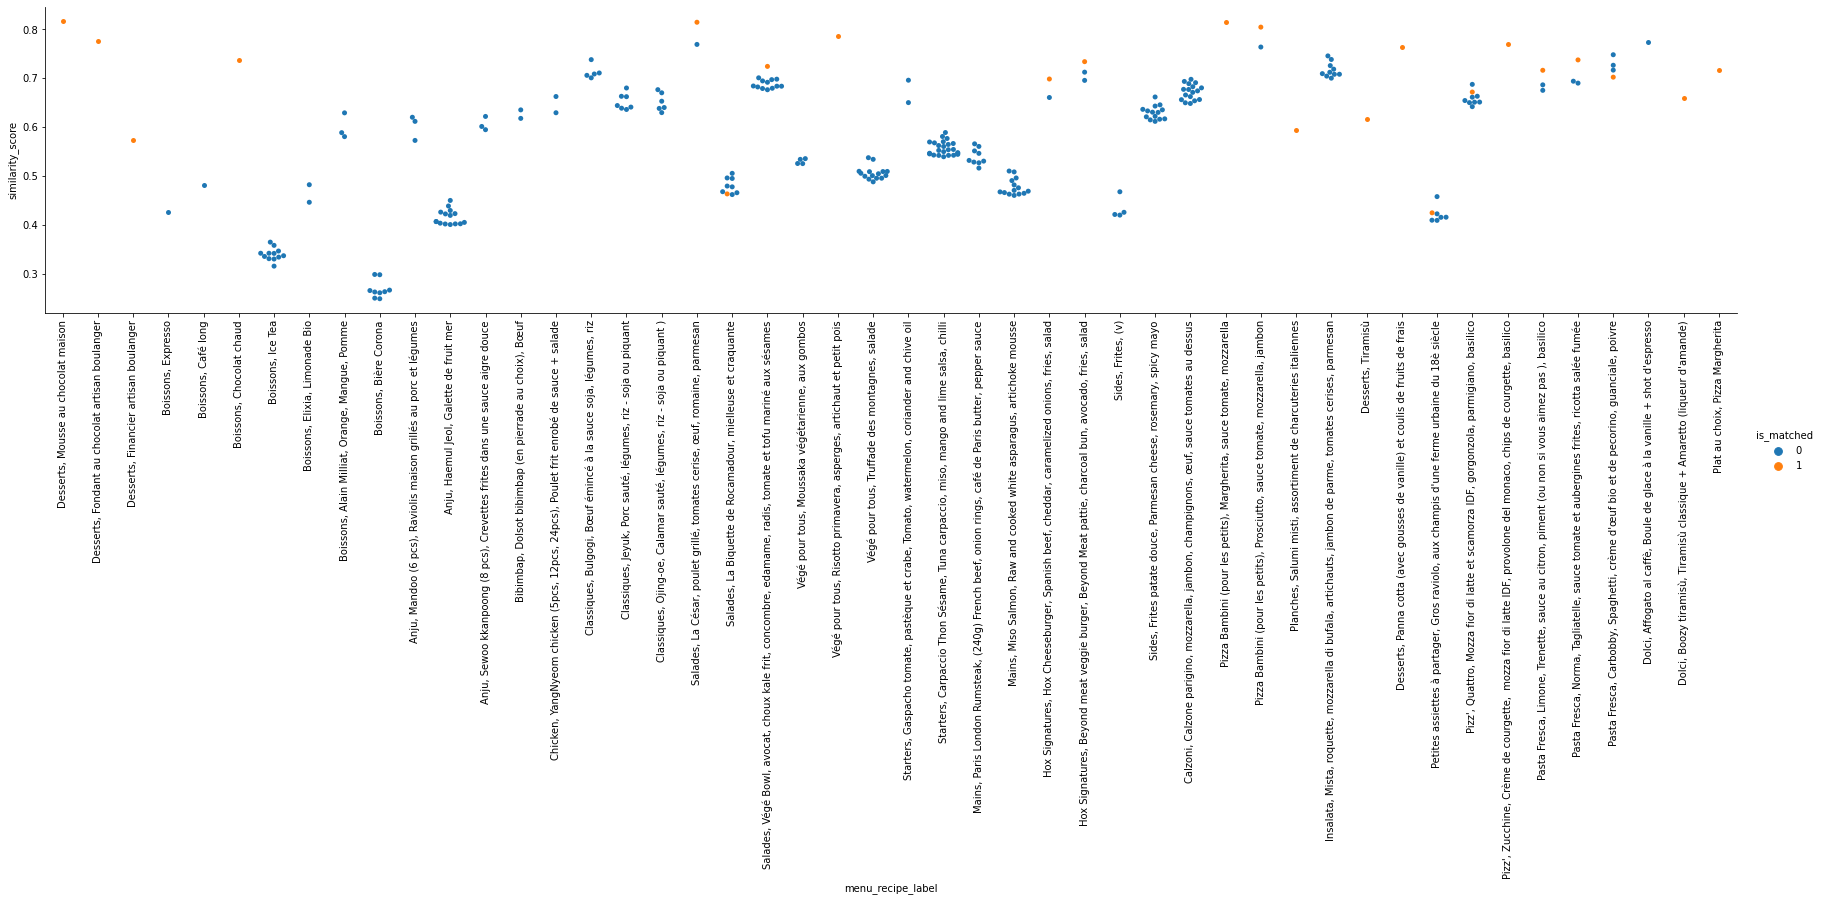

In [ ]:
fig = sns.catplot(data = df_res_step1, x = 'menu_recipe_label', y = 'similarity_score',  \
                  hue = 'is_matched', kind = 'swarm', aspect = 5)
fig.set_xticklabels(rotation=90);

## Matching by building new recipes from preselected ones

In [ ]:
df_res_step1.head(5)

,menu_recipe_label,jow_guess,similarity_rank,similarity_score,is_matched
0,"Desserts, Mousse au chocolat maison",Mousse au chocolat maison,1,0.817191,1
1,"Desserts, Fondant au chocolat artisan boulanger",Fondant au chocolat,1,0.775830,1
2,"Desserts, Financier artisan boulanger",Financier à la framboise,1,0.572464,1
3,"Boissons, Expresso",Affogato,1,0.425797,0
4,"Boissons, Café long",Affogato,1,0.482182,0


In [ ]:
jow_data.head(2)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
Yakitori bœuf fromage,10 minutes,"[[80 g, Bœuf (carpaccio)], [100 g, Emmental], [1 càs, Sauce Teriyaki], [70 g, Riz], [6, Pics à brochette]]",Yakitori boeuf fromage,"[Boeuf, Emmental, Sauce Teriyaki, Riz]","Yakitori boeuf fromage, Boeuf, Emmental, Sauce Teriyaki, Riz"
Gnocchis Epinards Gorgonzola,5 minutes,"[[150 g, Gnocchi], [100 g, Epinard (frais)], [30 g, Gorgonzola], [5 cl, Crème liquide]]",Gnocchis Epinards Gorgonzola,"[Gnocchi, Epinard, Gorgonzola, Crème liquide]","Gnocchis Epinards Gorgonzola, Gnocchi, Epinard, Gorgonzola, Crème liquide"


In [ ]:
# Extract the quantity for the ingredient 'ingredient' in the jow recipe 'recipe'
# Uses the dataframe 'jow_data' and the list 'meaningless_jow_ingredients' (not well written)
def extract_ingredient_quantity(ingredient, recipe):
    recipe_df = jow_data[jow_data['recipe_name']==recipe]

    x_ingredients = []      # ingredients of the 'recipe'
    x_quantities = []       # quantities of 'recipe' ingredients
    for x in recipe_df['ingredients_with_quantity'].values[0]:
        if len(x)>1:         
            x_ingredient = x[-1]    # the ingredient is the last element of the list x
            x_quantity = x[-2]      # x[0] might be "Faculatif" and not the quantity
            if x_ingredient not in meaningless_jow_ingredients:   # keep only meaningfull ingredients
                x_ingredient = remove_ligatures(x_ingredient)
                x_ingredients.append(x_ingredient) 
                x_quantities.append(x_quantity)

    x_ingredients = [re.sub("[\(\[].*?[\)\]]", "", ing) for ing in x_ingredients]  #remove informations in parenthesis
    # remove blank at the end of the string that remained when parenthesis have been removed
    x_ingredients = [ing[:-1] if ing[-1]==" " else ing for ing in x_ingredients]   

    # Get the quantity corresponding to 'ingredient'
    # ... Test if the ingredient is present in the recipe
    if ingredient not in x_ingredients:
        raise ValueError("The ingredient is not present in this recipe")

    # ... In principle, there might be several quantities (since parenthesis have been removed above)
    match_indices = [idx for idx, x_ing in enumerate(x_ingredients) if x_ing==ingredient]
    quantities = [x_quantities[idx] for idx in match_indices]

    # ... Extract the quantities with units
    def floatenize(n):  # Utility function to convert a string n into a float
        try:
            n = float(n)
        except ValueError:
            num, denom = n.split('/')
            n = float(num) / float(denom)
        return n

    for idx, q in enumerate(quantities):
        if len(q.split(" "))==1:
            nb = floatenize(q.split(" ")[0])
            unit = "no units"
        else:
            nb, unit = q.split(" ")
            nb = floatenize(nb)

        quantities[idx] = (nb, unit)

    # ... Compute the average quantity
    units = [q[1] for q in quantities]
    nbs = [q[0] for q in quantities]
    if len(set(units))!=1:    # Check all units are the same
        raise ValueError("Units are not the same in extract_ingredient_quantity")
    else:
        nb = np.array(nbs).mean()
        unit = units[0]

    return nb, unit


# Function to look for the pre-selected recipes + their scores in the dataframe 'df_res_step1'
def find_closest_recipes(query):
    df = df_res_step1[df_res_step1['menu_recipe_label']==query]

    # List of JOW recipes preselected with NLP
    recipes_list = list(df.groupby("menu_recipe_label")['jow_guess'].agg(list))[0]
    #print(recipes_list)

    # List of their similarity scores
    recipes_scores = list(df.groupby("menu_recipe_label")['similarity_score'].agg(list))[0]
    #print(recipes_scores)

    return recipes_list, recipes_scores


# Build a new recipe as closest as possible to query
# using the pre-selected recipes listed in recipes_list
# with their scores listed in recipes_scores
# (Uses the dataframe 'jow_data' (not well written))
def build_closest_recipe(query, recipes_list, recipes_scores):
    # List of ingredients of the pre-selected recipes
    jow_subset = jow_data[jow_data['recipe_name'].isin(recipes_list)]
    display(jow_subset)
    ingredients_list = jow_subset['ingredients'].values
    ingredients_list = list(itertools.chain.from_iterable(ingredients_list)) # Flatten the list
    #ingredients_list = [s.lower() for s in ingredients_list]   # lower case
    ingredients_list = list(set(ingredients_list))        # remove doublons
    #print(ingredients_list)

    # Here I think we should add a step to reduce the length of ingredients_list
    # by comparing with the ingredients in the menu recipe (query)
    # ...
    # ...

    # Evaluate the quantity for each ingredient in the new recipe
    new_recipe = []
    for ing in ingredients_list:
        #print("ingredient = ", ing)
        quantities = []   # list of quantities in each recipe
        for idx, recipe in enumerate(recipes_list):
            #print("recipe = ", recipe)
            recipe_score = recipes_scores[idx]
            try:    # if the ingredient is present in the recipe
                quantity, unit = extract_ingredient_quantity(ing, recipe)  
            except ValueError:
                quantity = 0
                unit = 'unit_tag'

            # Normalize the quantity by the contribution of the recipe
            quantity = quantity * recipe_score / max(recipes_scores)
            quantities.append((np.round(quantity, 2), unit))

        #print("quantities = ", quantities)
        # ... Compute the average quantity
        nbs = [q[0] for q in quantities]
        units = [q[1] for q in quantities]
        units = list(set(units))    # remove doublons

        if 'unit_tag' in units:
            units.remove('unit_tag')
        if len(set(units))!=1:    # Check all units are the same
            print("ingredient = ", ing)
            print(units)
            raise ValueError("Units are not the same in build_closest_recipe")
        else:
            nb = np.array(nbs).mean()    # average quantity
            unit = units[0]

        new_recipe.append((np.round(nb, 2), unit, ing))

    return new_recipe


# Returns the matched recipe (string) in the database if there are only one pre-selected recipe
# else returns the ingredients list of the new recipe
def compute_closest_recipe(query):
    # Pre-selected recipes with their similarity scores
    recipes_list, recipes_scores = find_closest_recipes(query)

    if len(recipes_list)==1:   # only one pre-selected recipe
        recipe_guess = recipes_list[0]
    else:
        recipe_guess = build_closest_recipe(query, recipes_list, recipes_scores)

    return recipe_guess


        

    


In [ ]:
# Check
#q = extract_ingredient_quantity('Carotte', 'Veggie noodles ramen')
#q = extract_ingredient_quantity('Ail', 'Veggie noodles ramen')
#q = extract_ingredient_quantity('Boeuf', 'Veggie noodles ramen')
q = extract_ingredient_quantity('Bouillon de légumes', 'Veggie noodles ramen')
print(q)

(0.25, 'no units')


In [ ]:
query = "Anju, Mandoo (6 pcs), Raviolis maison grillés au porc et légumes"
compute_closest_recipe(query)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
"Sandwich poivrons rôtis, épinard, feta",plat froid,"[[2 tran., Pain de campagne (tranché)], [20 g, Houmous], [30 g, Poivrons grillés], [1 poignée, Epinard (frais)]]","Sandwich poivrons rôtis, épinard, feta","[Pain de campagne, Houmous, Poivrons grillés, Epinard]","Sandwich poivrons rôtis, épinard, feta, Pain de campagne, Houmous, Poivrons grillés, Epinard"
Veggie noodles ramen,11 minutes,"[[1/5 gou., Ail], [1/2 càc, Pâte de curry (rouge)], [1, Œuf], [1, Carotte (frais)], [1/4, Bouillon de légumes (cube)], [60 g, Petits pois (frais)], [120 g, Nouilles précuites (Ramen)]]",Veggie noodles ramen,"[Ail, Pâte de curry, oeuf, Carotte, Bouillon de légumes, Petits pois, Nouilles précuites]","Veggie noodles ramen, Ail, Pâte de curry, oeuf, Carotte, Bouillon de légumes, Petits pois, Nouilles précuites"
Nouilles de riz & porc sauté,7 minutes,"[[80 g, Nouilles de riz], [80 g, Chair à saucisse], [50 g, Concombre], [20 g, Cacahuète], [1 pinc., Piment d'Espelette], [2 càs, Sauce soja salée], [Facultatif, 1/10 bou., Menthe (feuilles)]]",Nouilles de riz & porc sauté,"[Nouilles de riz, Chair à saucisse, Concombre, Cacahuète, Piment d'Espelette, Sauce soja salée, Menthe]","Nouilles de riz & porc sauté, Nouilles de riz, Chair à saucisse, Concombre, Cacahuète, Piment d'Espelette, Sauce soja salée, Menthe"


[(0.07, 'gou.', 'Ail'),
 (0.33, 'pinc.', "Piment d'Espelette"),
 (0.62, 'tran.', 'Pain de campagne'),
 (0.08, 'no units', 'Bouillon de légumes'),
 (26.67, 'g', 'Chair à saucisse'),
 (0.33, 'no units', 'Carotte'),
 (16.67, 'g', 'Concombre'),
 (19.73, 'g', 'Petits pois'),
 (6.16, 'g', 'Houmous'),
 (39.46, 'g', 'Nouilles précuites'),
 (0.03, 'bou.', 'Menthe'),
 (9.24, 'g', 'Poivrons grillés'),
 (0.16, 'càc', 'Pâte de curry'),
 (0.67, 'càs', 'Sauce soja salée'),
 (6.67, 'g', 'Cacahuète'),
 (26.67, 'g', 'Nouilles de riz'),
 (0.31, 'poignée', 'Epinard'),
 (0.33, 'no units', 'oeuf')]

## Test the approach for menu recipes with explicit matches found by hand

In [ ]:
menu_data_withmatch = menu_data[menu_data['Closest JOW recipe by hand']!='no match']
print("Number of queries = ", menu_data_withmatch.shape[0])

Number of queries =  30


In [ ]:
menu_data_withmatch

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Menu Title and Subtitle,Menu all
0,7,burgart_205074_c70.jpg,Desserts,Mousse au chocolat maison,,Mousse au chocolat maison,"Desserts, Mousse au chocolat maison","Desserts, Mousse au chocolat maison"
1,8,burgart_205074_c70.jpg,Desserts,Fondant au chocolat artisan boulanger,,Fondant au chocolat,"Desserts, Fondant au chocolat artisan boulanger","Desserts, Fondant au chocolat artisan boulanger"
2,9,burgart_205074_c70.jpg,Desserts,Financier artisan boulanger,,"['Financier cerises noires & pistache', 'Financier à la framboise']","Desserts, Financier artisan boulanger","Desserts, Financier artisan boulanger"
5,12,burgart_205074_c70.jpg,Boissons,Chocolat chaud,,Chocolat chaud,"Boissons, Chocolat chaud","Boissons, Chocolat chaud"
12,19,Carte-in-seoul.png,Anju,Sewoo kkanpoong (8 pcs),Crevettes frites dans une sauce aigre douce,"['Crevettes teriyaki', 'Crevettes miel sésame']","Anju, Sewoo kkanpoong (8 pcs)","Anju, Sewoo kkanpoong (8 pcs), Crevettes frites dans une sauce aigre douce"
15,22,Carte-in-seoul.png,Classiques,Bulgogi,"Bœuf émincé à la sauce soja, légumes, riz","['Wok de bœuf légumes croquants', 'Bœuf thaï', 'Bœuf sauté au chou', 'Aiguillettes de bœuf & légumes poêlés']","Classiques, Bulgogi","Classiques, Bulgogi, Bœuf émincé à la sauce soja, légumes, riz"
16,23,Carte-in-seoul.png,Classiques,Jeyuk,"Porc sauté, légumes, riz - soja ou piquant",Porc au caramel,"Classiques, Jeyuk","Classiques, Jeyuk, Porc sauté, légumes, riz - soja ou piquant"
18,27,Carte-Restaurant-Nelsons-Paris-Jour-2-1024x724.jpg,Salades,La César,"poulet grillé, tomates cerise, œuf, romaine, parmesan",Salade César,"Salades, La César","Salades, La César, poulet grillé, tomates cerise, œuf, romaine, parmesan"
19,28,Carte-Restaurant-Nelsons-Paris-Jour-2-1024x724.jpg,Salades,La Biquette de Rocamadour,mielleuse et craquante,"['Salade de chèvre chaud', 'Salade chèvre, miel & pignons', 'Salade aux croustillants de chèvre']","Salades, La Biquette de Rocamadour","Salades, La Biquette de Rocamadour, mielleuse et craquante"
20,29,Carte-Restaurant-Nelsons-Paris-Jour-2-1024x724.jpg,Salades,Végé Bowl,"avocat, choux kale frit, concombre, edamame, radis, tomate et tofu mariné aux sésames",Vegan poke bowl,"Salades, Végé Bowl","Salades, Végé Bowl, avocat, choux kale frit, concombre, edamame, radis, tomate et tofu mariné aux sésames"


In [ ]:
query = "Desserts, Mousse au chocolat maison"
compute_closest_recipe(query)

'Mousse au chocolat maison'

In [ ]:
query = "Salades, La César, poulet grillé, tomates cerise, œuf, romaine, parmesan"
compute_closest_recipe(query)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
Salade César,13 minutes,"[[1, Poulet (escalope)], [2 poignées, Salade (coeur de laitue)], [20 g, Parmesan (morceaux)], [1 tran., Pain de campagne (tranché)], [1/4, Œuf], [1/4 càs, Moutarde], [1/4 gou., Ail], [4 cl, Huile de tournesol]]",Salade César,"[Poulet, Salade, Parmesan, Pain de campagne, oeuf, Moutarde, Ail, Huile de tournesol]","Salade César, Poulet, Salade, Parmesan, Pain de campagne, oeuf, Moutarde, Ail, Huile de tournesol"
Salade au poulet pané,6 minutes,"[[1, Poulet (pané)], [2 poignées, Salade (Mélange)], [100 g, Tomate cerise], [15 g, Parmesan (morceaux)], [1 càc, Crème balsamique]]",Salade au poulet pané,"[Poulet, Salade, Tomate cerise, Parmesan, Crème balsamique]","Salade au poulet pané, Poulet, Salade, Tomate cerise, Parmesan, Crème balsamique"


[(1.94, 'poignées', 'Salade'),
 (0.12, 'gou.', 'Ail'),
 (0.5, 'tran.', 'Pain de campagne'),
 (17.08, 'g', 'Parmesan'),
 (47.22, 'g', 'Tomate cerise'),
 (2.0, 'cl', 'Huile de tournesol'),
 (0.97, 'no units', 'Poulet'),
 (0.47, 'càc', 'Crème balsamique'),
 (0.12, 'càs', 'Moutarde'),
 (0.12, 'no units', 'oeuf')]

The new recipe is slightly better than 'Salade César' (which is the one with the highest similarity score) since it includes 'Tomate cerise'.

In [ ]:
query = "Pasta Fresca, Carbobby, Spaghetti, crème d'œuf bio et de pecorino, guanciale, poivre"
compute_closest_recipe(query)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara,"[Pâtes, Pancetta, oeuf, Parmesan]","Pasta alla carbonara, Pâtes, Pancetta, oeuf, Parmesan"
Creamy Eggs & Prosciutto pasta,8 minutes,"[[100 g, Pâtes (Pappardelle)], [2 tran., Jambon cru (Prosciutto)], [5 cl, Crème liquide], [1/2 càs, Ricotta], [1, Œuf], [Facultatif, 1/10 bou., Basilic (frais)]]",Creamy Eggs & Prosciutto pasta,"[Pâtes, Jambon cru, Crème liquide, Ricotta, oeuf, Basilic]","Creamy Eggs & Prosciutto pasta, Pâtes, Jambon cru, Crème liquide, Ricotta, oeuf, Basilic"
Pasta carbo poireaux,15 minutes,"[[100 g, Pâtes (Linguine)], [1/2, Poireau], [15 g, Parmesan (râpé)], [1/2, Œuf], [50 g]]",Pasta carbo poireaux,"[Pâtes, Poireau, Parmesan, oeuf]","Pasta carbo poireaux, Pâtes, Poireau, Parmesan, oeuf"
Creamy green pasta,10 minutes,"[[100 g, Pâtes (Pipe rigate)], [80 g, Petits pois (surgelés)], [80 g, Courgette], [1 càs, Crème fraîche épaisse], [1/4, Citron jaune], [1 pinc., Piment d'Espelette]]",Creamy green pasta,"[Pâtes, Petits pois, Courgette, Crème fraîche épaisse, Citron jaune, Piment d'Espelette]","Creamy green pasta, Pâtes, Petits pois, Courgette, Crème fraîche épaisse, Citron jaune, Piment d'Espelette"


[(0.02, 'bou.', 'Basilic'),
 (0.06, 'no units', 'Citron jaune'),
 (0.24, 'pinc.', "Piment d'Espelette"),
 (0.12, 'càs', 'Ricotta'),
 (96.7, 'g', 'Pâtes'),
 (13.03, 'g', 'Parmesan'),
 (0.61, 'no units', 'oeuf'),
 (19.16, 'g', 'Petits pois'),
 (1.25, 'cl', 'Crème liquide'),
 (0.24, 'càs', 'Crème fraîche épaisse'),
 (0.12, 'no units', 'Poireau'),
 (0.7, 'tran.', 'Pancetta'),
 (19.16, 'g', 'Courgette'),
 (0.5, 'tran.', 'Jambon cru')]

We have too many ingredients in our new recipe! But some of them appear with low quantity, e.g. 'Poireau' since it comes from only one recipe -> **Some ingredients (with low quantity  and/or low ecoscores) should be removed.**  
Note the closest recipe in JOW is 'Pasta alla carbonara', it is pre-selected with NLP but not with the best similarity score (only the fourth).

## Test the approach for menu recipes without explicit matches found by hand

In [ ]:
menu_data_withoutmatch = menu_data[menu_data['Closest JOW recipe by hand']=='no match']
print("Number of queries = ", menu_data_withoutmatch.shape[0])

Number of queries =  18


In [ ]:
menu_data_withoutmatch

,Unnamed: 0,Menu filename,Menu Title,Menu Subtitle,Menu Ingredients,Closest JOW recipe by hand,Menu Title and Subtitle,Menu all
3,10,burgart_205074_c70.jpg,Boissons,Expresso,,no match,"Boissons, Expresso","Boissons, Expresso"
4,11,burgart_205074_c70.jpg,Boissons,Café long,,no match,"Boissons, Café long","Boissons, Café long"
6,13,burgart_205074_c70.jpg,Boissons,Ice Tea,,no match,"Boissons, Ice Tea","Boissons, Ice Tea"
7,14,burgart_205074_c70.jpg,Boissons,Elixia,Limonade Bio,no match,"Boissons, Elixia","Boissons, Elixia, Limonade Bio"
8,15,burgart_205074_c70.jpg,Boissons,Alain Milliat,"Orange, Mangue, Pomme",no match,"Boissons, Alain Milliat","Boissons, Alain Milliat, Orange, Mangue, Pomme"
9,16,burgart_205074_c70.jpg,Boissons,Bière Corona,,no match,"Boissons, Bière Corona","Boissons, Bière Corona"
10,17,Carte-in-seoul.png,Anju,Mandoo (6 pcs),Raviolis maison grillés au porc et légumes,no match,"Anju, Mandoo (6 pcs)","Anju, Mandoo (6 pcs), Raviolis maison grillés au porc et légumes"
11,18,Carte-in-seoul.png,Anju,Haemul Jeol,Galette de fruit mer,no match,"Anju, Haemul Jeol","Anju, Haemul Jeol, Galette de fruit mer"
13,20,Carte-in-seoul.png,Bibimbap,Dolsot bibimbap (en pierrade au choix),Bœuf,no match,"Bibimbap, Dolsot bibimbap (en pierrade au choix)","Bibimbap, Dolsot bibimbap (en pierrade au choix), Bœuf"
14,21,Carte-in-seoul.png,Chicken,"YangNyeom chicken (5pcs, 12pcs, 24pcs)",Poulet frit enrobé de sauce + salade,no match,"Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs)","Chicken, YangNyeom chicken (5pcs, 12pcs, 24pcs), Poulet frit enrobé de sauce + salade"


In [ ]:
query = "Sides, Frites patate douce, Parmesan cheese, rosemary, spicy mayo"
compute_closest_recipe(query)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
Pasta alla carbonara,9 minutes,"[[100 g, Pâtes (spaghetti)], [3 tran., Pancetta], [1, Œuf], [40 g, Parmesan (morceaux)]]",Pasta alla carbonara,"[Pâtes, Pancetta, oeuf, Parmesan]","Pasta alla carbonara, Pâtes, Pancetta, oeuf, Parmesan"
Pasta Alfredo,12 minutes,"[[100 g, Pâtes (Tagliatelles)], [1, Poulet (escalope)], [10 cl, Crème liquide], [1/2 gou., Ail], [1 càs, Parmesan (râpé)]]",Pasta Alfredo,"[Pâtes, Poulet, Crème liquide, Ail, Parmesan]","Pasta Alfredo, Pâtes, Poulet, Crème liquide, Ail, Parmesan"
Poulet à la Toscane,10 minutes,"[[100 g, Pâtes fraîches], [1, Poulet (escalope)], [50 g, Tomate séchée], [10 cl, Crème liquide], [2 poignées, Epinard (frais)], [1 càs, Parmesan (râpé)], [1/4 gou., Ail]]",Poulet à la Toscane,"[Pâtes fraîches, Poulet, Tomate séchée, Crème liquide, Epinard, Parmesan, Ail]","Poulet à la Toscane, Pâtes fraîches, Poulet, Tomate séchée, Crème liquide, Epinard, Parmesan, Ail"
Poêlée de patate douce & feta,20 minutes,"[[200 g, Patate douce], [1, Œuf], [40 g, Feta], [Facultatif, 1/10 bou., Persil (frais)], [1/2 pinc., Piment d'Espelette], [1/4 gou., Ail]]",Poêlée de patate douce & feta,"[Patate douce, oeuf, Feta, Persil, Piment d'Espelette, Ail]","Poêlée de patate douce & feta, Patate douce, oeuf, Feta, Persil, Piment d'Espelette, Ail"
Spaghetti endives & prosciutto,10 minutes,"[[100 g, Pâtes (spaghetti)], [100 g, Endives], [1 tran., Jambon cru (Prosciutto)], [1/2 càs, Parmesan (râpé)], [1 càc, Sucre (en poudre)]]",Spaghetti endives & prosciutto,"[Pâtes, Endives, Jambon cru, Parmesan, Sucre]","Spaghetti endives & prosciutto, Pâtes, Endives, Jambon cru, Parmesan, Sucre"
Pumpkin pasta,21 minutes,"[[1/8, Potimarron], [100 g, Pâtes (Rigatoni)], [1/4 gou., Ail], [25 g, Parmesan (râpé)], [5 cl, Crème liquide]]",Pumpkin pasta,"[Potimarron, Pâtes, Ail, Parmesan, Crème liquide]","Pumpkin pasta, Potimarron, Pâtes, Ail, Parmesan, Crème liquide"
Quiche ratatouille & mozzarella,45 minutes,"[[1, Pâte brisée], [3, Œuf], [10 cl, Lait], [10 cl, Crème liquide], [1, Mozzarella (boule)], [300 g, Ratatouille], [1 càc, Herbes de provence]]",Quiche ratatouille & mozzarella,"[Pâte brisée, oeuf, Lait, Crème liquide, Mozzarella, Ratatouille, Herbes de provence]","Quiche ratatouille & mozzarella, Pâte brisée, oeuf, Lait, Crème liquide, Mozzarella, Ratatouille, Herbes de provence"
One pot parmigiano pasta,20 minutes,"[[100 g, Pâtes (Pipe rigate)], [25 cl, Lait], [30 g, Parmesan (râpé)], [10 g, Beurre]]",One pot parmigiano pasta,"[Pâtes, Lait, Parmesan, Beurre]","One pot parmigiano pasta, Pâtes, Lait, Parmesan, Beurre"
Grilled cheese tomate mozza,5 minutes,"[[4 tran., Pain de mie], [80 g, Mozzarella (boule)], [1, Tomate], [2 poignées, Salade (roquette)], [1 càs, Sauce pesto]]",Grilled cheese tomate mozza,"[Pain de mie, Mozzarella, Tomate, Salade, Sauce pesto]","Grilled cheese tomate mozza, Pain de mie, Mozzarella, Tomate, Salade, Sauce pesto"
Cheesecake feta courgette menthe,50 minutes,"[[200 g, Cracker], [2 càs, Parmesan (râpé)], [80 g, Beurre], [250 g, Feta], [3, Œuf], [1 gou., Ail], [2, Courgette], [1/2 bou., Menthe (feuilles)]]",Cheesecake feta courgette menthe,"[Cracker, Parmesan, Beurre, Feta, oeuf, Ail, Courgette, Menthe]","Cheesecake feta courgette menthe, Cracker, Parmesan, Beurre, Feta, oeuf, Ail, Courgette, Menthe"


ingredient =  Parmesan
['g', 'càs']


ValueError: ignored

Too many pre-selected recipes! The one with highest similarity score is 'Pâtes chorizo & ricotta' which has nothing to do with the menu recipe.  
Also, we get an error because one ingredient, 'Parmesan', is expressed in different units ['g', 'càs'] and it is not possible to calculate the average quantity.  
**In this case, what would be the predicition of GPT3 (tested through the openAI interface https://platform.openai.com/playground with the model 'test-davinci-003)?**  

Quels sont les ingrédients pour une personne de la recette "Sides, Frites patate douce, Parmesan cheese, rosemary, spicy mayo"?  

-1 tasse de frites de patate douce  
-1/4 tasse de parmesan râpé  
-1 cuillère à café de romarin frais  
-1 cuillère à soupe de mayonnaise épicée  


In [ ]:
query = "Anju, Mandoo (6 pcs), Raviolis maison grillés au porc et légumes"
compute_closest_recipe(query)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
"Sandwich poivrons rôtis, épinard, feta",plat froid,"[[2 tran., Pain de campagne (tranché)], [20 g, Houmous], [30 g, Poivrons grillés], [1 poignée, Epinard (frais)]]","Sandwich poivrons rôtis, épinard, feta","[Pain de campagne, Houmous, Poivrons grillés, Epinard]","Sandwich poivrons rôtis, épinard, feta, Pain de campagne, Houmous, Poivrons grillés, Epinard"
Veggie noodles ramen,11 minutes,"[[1/5 gou., Ail], [1/2 càc, Pâte de curry (rouge)], [1, Œuf], [1, Carotte (frais)], [1/4, Bouillon de légumes (cube)], [60 g, Petits pois (frais)], [120 g, Nouilles précuites (Ramen)]]",Veggie noodles ramen,"[Ail, Pâte de curry, oeuf, Carotte, Bouillon de légumes, Petits pois, Nouilles précuites]","Veggie noodles ramen, Ail, Pâte de curry, oeuf, Carotte, Bouillon de légumes, Petits pois, Nouilles précuites"
Nouilles de riz & porc sauté,7 minutes,"[[80 g, Nouilles de riz], [80 g, Chair à saucisse], [50 g, Concombre], [20 g, Cacahuète], [1 pinc., Piment d'Espelette], [2 càs, Sauce soja salée], [Facultatif, 1/10 bou., Menthe (feuilles)]]",Nouilles de riz & porc sauté,"[Nouilles de riz, Chair à saucisse, Concombre, Cacahuète, Piment d'Espelette, Sauce soja salée, Menthe]","Nouilles de riz & porc sauté, Nouilles de riz, Chair à saucisse, Concombre, Cacahuète, Piment d'Espelette, Sauce soja salée, Menthe"


[(0.07, 'gou.', 'Ail'),
 (0.33, 'pinc.', "Piment d'Espelette"),
 (0.62, 'tran.', 'Pain de campagne'),
 (0.08, 'no units', 'Bouillon de légumes'),
 (26.67, 'g', 'Chair à saucisse'),
 (0.33, 'no units', 'Carotte'),
 (16.67, 'g', 'Concombre'),
 (19.73, 'g', 'Petits pois'),
 (6.16, 'g', 'Houmous'),
 (39.46, 'g', 'Nouilles précuites'),
 (0.03, 'bou.', 'Menthe'),
 (9.24, 'g', 'Poivrons grillés'),
 (0.16, 'càc', 'Pâte de curry'),
 (0.67, 'càs', 'Sauce soja salée'),
 (6.67, 'g', 'Cacahuète'),
 (26.67, 'g', 'Nouilles de riz'),
 (0.31, 'poignée', 'Epinard'),
 (0.33, 'no units', 'oeuf')]

The JOW recipe with highest similarity score is 'Nouilles de riz & porc sauté'.  
Our new recipe is bad, there is no pork inside.  
Let's ask GPT3:  
Quelle est la recette pour une personne de la recette "Anju, Mandoo (6 pcs), Raviolis maison grillés au porc et légumes"?

Ingrédients :

- 2 tasses de farine  
- 1/4 tasse de sel  
- 1/4 tasse d'huile végétale  
- 1/2 tasse d'eau tiède  
- 1/4 tasse de lait  
- 1 oeuf  
- 1/2 tasse de fromage râpé  
- 1/2 tasse de poitrine de porc hachée  
- 1/2 tasse de carottes hachées  
- 1/4 tasse de maïs  
- 2 gousses d'ail hachées  
- 1/4 tasse de coriandre hachée  
- Sel et poivre, au goût  


In [ ]:
query = "Végé pour tous, Moussaka végétarienne, aux gombos"
compute_closest_recipe(query)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
Tikka Masala veggie,11 minutes,"[[1/4, Chou-fleur (frais)], [80 g, Sauce tikka masala], [70 g, Riz]]",Tikka Masala veggie,"[Chou-fleur, Sauce tikka masala, Riz]","Tikka Masala veggie, Chou-fleur, Sauce tikka masala, Riz"
Couscous veggie,20 minutes,"[[70 g, Semoule], [1, Carotte (frais)], [40 g, Pois chiches (cuits)], [1, Échalote], [1/2 càc, Harissa (pâte)], [1/2, Courgette], [1 càc, Ras el hanout], [1/2, Bouillon de légumes (cube)]]",Couscous veggie,"[Semoule, Carotte, Pois chiches, Échalote, Harissa, Courgette, Ras el hanout, Bouillon de légumes]","Couscous veggie, Semoule, Carotte, Pois chiches, Échalote, Harissa, Courgette, Ras el hanout, Bouillon de légumes"
"Nuggets veggie, riz & brocolis",10 minutes,"[[70 g, Riz], [100 g, Nuggets végétal], [100 g, Brocoli (frais)]]","Nuggets veggie, riz & brocolis","[Riz, Nuggets végétal, Brocoli]","Nuggets veggie, riz & brocolis, Riz, Nuggets végétal, Brocoli"
Roasted veggies & hummus bowl,25 minutes,"[[200 g, Patate douce], [80 g, Pois chiches (cuits)], [60 g, Houmous], [1 poignée, Salade (mélange mâche-roquette)], [1 càc, Paprika], [Facultatif, 1/10 bou., Coriandre (frais)]]",Roasted veggies & hummus bowl,"[Patate douce, Pois chiches, Houmous, Salade, Paprika, Coriandre]","Roasted veggies & hummus bowl, Patate douce, Pois chiches, Houmous, Salade, Paprika, Coriandre"


[(0.24, 'poignée', 'Salade'),
 (0.12, 'càc', 'Harissa'),
 (0.25, 'càc', 'Ras el hanout'),
 (0.12, 'no units', 'Courgette'),
 (0.24, 'càc', 'Paprika'),
 (0.12, 'no units', 'Bouillon de légumes'),
 (0.02, 'bou.', 'Coriandre'),
 (0.25, 'no units', 'Carotte'),
 (0.06, 'no units', 'Chou-fleur'),
 (24.52, 'g', 'Brocoli'),
 (14.72, 'g', 'Houmous'),
 (20.0, 'g', 'Sauce tikka masala'),
 (34.67, 'g', 'Riz'),
 (49.07, 'g', 'Patate douce'),
 (29.6, 'g', 'Pois chiches'),
 (24.52, 'g', 'Nuggets végétal'),
 (17.45, 'g', 'Semoule'),
 (0.25, 'no units', 'Échalote')]

Our new recipe is bad bad bad!  
Help me GPT3?  

Quelle est la recette pour une personne de  "Végé pour tous, Moussaka végétarienne, aux gombos"?

Ingrédients :

- 1 gros gombo  
- 1/4 tasse d'huile d'olive
- 1 oignon rouge, haché  
- 2 gousses d'ail, hachées  
- 1 boîte (14,5 oz) de tomates en dés  
- 1/2 c. à thé de sel  
- 1/4 c. à thé de poivre noir  
- 1 c. à thé de basilic séché  
- 1/2 c. à thé de thym séché  
- 1/2 tasse de riz cuit  
- 1/2 tasse de lait de soja  
- 2 c. à soupe de fromage râpé  
- 1/4 tasse de chapelure  
  
-> weird! There is rice in moussaka

In [ ]:
query = "Calzoni, Calzone parigino, mozzarella, jambon, champignons, œuf, sauce tomates au dessus"
compute_closest_recipe(query)

,cuisson,ingredients_with_quantity,recipe_name,ingredients,name_with_ingredients
Pizza Parma,10 minutes,"[[1, Pâte à pizza], [60 g, Tomate (purée)], [3 tran., Jambon cru], [1, Mozzarella (boule)], [1 poignée, Salade (roquette)]]",Pizza Parma,"[Pâte à pizza, Tomate, Jambon cru, Mozzarella, Salade]","Pizza Parma, Pâte à pizza, Tomate, Jambon cru, Mozzarella, Salade"
Rumsteak à l'italienne,4 minutes,"[[1, Bœuf (rumsteck)], [2 poignées, Salade (roquette)], [30 g, Parmesan (morceaux)], [1 càc, Sauce pesto], [1 càs, Pignons de pin]]",Rumsteak à l'italienne,"[Boeuf, Salade, Parmesan, Sauce pesto, Pignons de pin]","Rumsteak à l'italienne, Boeuf, Salade, Parmesan, Sauce pesto, Pignons de pin"
Pizza printanière,10 minutes,"[[1, Pâte à pizza], [140 g, Petits pois (surgelés)], [4 tran., Jambon cru (Prosciutto)], [1, Œuf], [1 càs, Sauce pesto], [1, Mozzarella (boule)], [Facultatif, 2 poignées, Salade (roquette)]]",Pizza printanière,"[Pâte à pizza, Petits pois, Jambon cru, oeuf, Sauce pesto, Mozzarella, Salade]","Pizza printanière, Pâte à pizza, Petits pois, Jambon cru, oeuf, Sauce pesto, Mozzarella, Salade"
Piadina façon tarte,2 minutes,"[[1/2, Mozzarella (boule)], [150 g, Tomates multicolores], [1, Tortilla (blé)], [2 tran., Jambon cru (Prosciutto)], [1/10 bou., Basilic (frais)], [1 càs, Ricotta]]",Piadina façon tarte,"[Mozzarella, Tomates multicolores, Tortilla, Jambon cru, Basilic, Ricotta]","Piadina façon tarte, Mozzarella, Tomates multicolores, Tortilla, Jambon cru, Basilic, Ricotta"
Brochette melon & jambon,plat froid,"[[Facultatif, 4, Pics à brochette], [1/4, Melon], [2 tran., Jambon cru (Prosciutto)], [1/10 bou., Basilic (frais)], [60 g, Mozzarella (mini)]]",Brochette melon & jambon,"[Melon, Jambon cru, Basilic, Mozzarella]","Brochette melon & jambon, Melon, Jambon cru, Basilic, Mozzarella"
Galette parma,3 minutes,"[[15 g, Tomate séchée], [1, Galette bretonne], [1/2, Mozzarella (boule)], [1/4 càs, Sauce pesto], [1 tran., Jambon cru]]",Galette parma,"[Tomate séchée, Galette bretonne, Mozzarella, Sauce pesto, Jambon cru]","Galette parma, Tomate séchée, Galette bretonne, Mozzarella, Sauce pesto, Jambon cru"
Bruschetta parma,plat froid,"[[2 tran., Pain de campagne (tranché)], [50 g, Mozzarella (boule)], [150 g, Tomate], [Facultatif, 1/10 bou., Basilic (frais)], [2 tran., Jambon cru]]",Bruschetta parma,"[Pain de campagne, Mozzarella, Tomate, Basilic, Jambon cru]","Bruschetta parma, Pain de campagne, Mozzarella, Tomate, Basilic, Jambon cru"
Quiche artichaut & parma,50 minutes,"[[1, Pâte brisée], [1, Mozzarella (boule)], [160 g, Artichauts marinés], [4 tran., Jambon cru (Prosciutto)], [3, Œuf], [10 cl, Lait], [10 cl, Crème liquide]]",Quiche artichaut & parma,"[Pâte brisée, Mozzarella, Artichauts marinés, Jambon cru, oeuf, Lait, Crème liquide]","Quiche artichaut & parma, Pâte brisée, Mozzarella, Artichauts marinés, Jambon cru, oeuf, Lait, Crème liquide"
Italian grilled cheese,4 minutes,"[[4 tran., Pain de mie], [2 càc, Sauce pesto], [4 tran., Jambon cru (Prosciutto)], [1 poignée, Salade (roquette)], [80 g, Mozzarella (boule)]]",Italian grilled cheese,"[Pain de mie, Sauce pesto, Jambon cru, Salade, Mozzarella]","Italian grilled cheese, Pain de mie, Sauce pesto, Jambon cru, Salade, Mozzarella"
Gratin de gnocchis à la mozzarella,16 minutes,"[[150 g, Gnocchi], [70 g, Tomate (purée)], [1/4, Mozzarella (boule)], [Facultatif, 1/10 bou., Basilic (frais)]]",Gratin de gnocchis à la mozzarella,"[Gnocchi, Tomate, Mozzarella, Basilic]","Gratin de gnocchis à la mozzarella, Gnocchi, Tomate, Mozzarella, Basilic"


ingredient =  Parmesan
['g', 'càs']


ValueError: ignored

Same problem as before.   
What about GPT3?  

Quelle est la recette pour une personne de  "Calzoni, Calzone parigino, mozzarella, jambon, champignons, œuf, sauce tomates au dessus"?

Ingrédients

- 1 pâte à pizza  
- 2 cuillères à soupe de sauce tomates  
- 2 tranches de jambon  
- 2 tranches de mozzarella  
- 2 champignons  
- 1 œuf  
